In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mltools as ml

data = np.genfromtxt("data/curve80.txt",delimiter=None) # load the text file
X = data[:,0]
X = np.atleast_2d(X).T # code expects shape (M,N) so make sure it's 2-dimensional
Y = data[:,1]
Xtr,Xte,Ytr,Yte = ml.splitData(X,Y,0.75) # split data set 75/25
print Xtr.shape, Xte.shape,Ytr.shape,Yte.shape

(60L, 1L) (20L, 1L) (60L,) (20L,)


In [2]:
lr = ml.linear.linearRegress( Xtr, Ytr ) # create and train model
xs = np.linspace(0,10,200) # densely sample possible x-values
xs = xs[:,np.newaxis] # force "xs" to be an Mx1 matrix (expected by our code)
ys = lr.predict( xs )


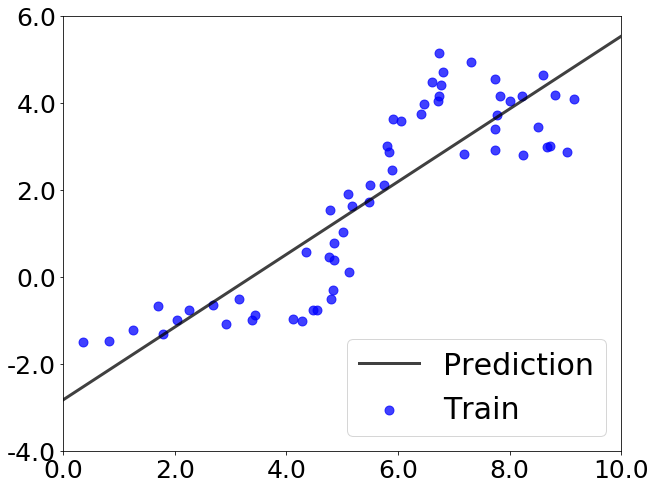

[[-2.82765049  0.83606916]]


In [3]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
    
ax.scatter(Xtr, Ytr, s=80, color='blue', alpha=0.75, label='Train')
ax.plot(xs, ys, lw=3, color='black', alpha=0.75, label='Prediction')

ax.set_xlim(0, 10)
ax.set_ylim(-4, 6)
ax.set_xticklabels(ax.get_xticks(), fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25)   

ax.legend(fontsize=30, loc=4)

plt.show()  
print lr.theta

In [8]:
degree = 2
XtrP = ml.transforms.fpoly(Xtr, degree, False)
lr = ml.linear.linearRegress(XtrP,Ytr)
XtrP = ml.transforms.fpoly(Xtr,degree,False)
XteP = ml.transforms.fpoly(Xte,degree,False)

print('training: ',lr.mse(XtrP,Ytr))
print('testing: ',lr.mse(XteP,Yte))

('training: ', 1.1259369366959995)
('testing: ', 2.2689904275255817)


('degree:', 1)


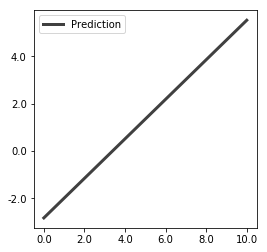

('degree:', 3)


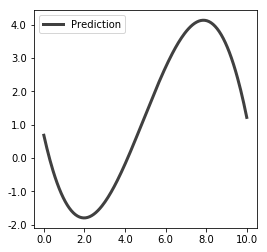

('degree:', 5)


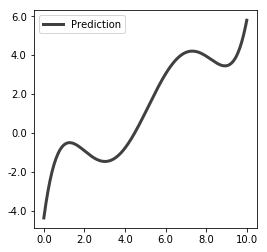

('degree:', 7)


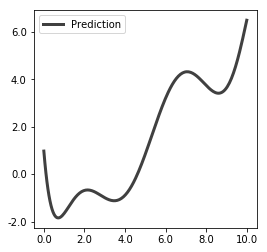

('degree:', 10)


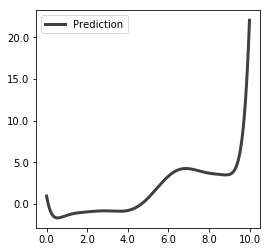

('degree:', 18)


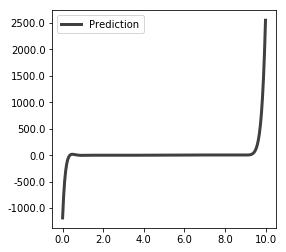

In [9]:
lr = ml.linear.linearRegress( Xtr, Ytr ) # create and train model
xs = np.linspace(0,10,200) # densely sample possible x-values
xs = xs[:,np.newaxis] # force "xs" to be an Mx1 matrix (expected by our code)
ys = lr.predict( xs ) 

degree = np.array([1, 3, 5, 7, 10, 18])

for i in degree:
    print ('degree:', i)
    # Create polynomial features up to "degree"; don't create constant feature
    # (the linear regression learner will add the constant feature automatically)
    XtrP = ml.transforms.fpoly(Xtr, i, bias=False)
    # Rescale the data matrix so that the features have similar ranges / variance
    XtrP,params = ml.transforms.rescale(XtrP)
    # "params" returns the transformation parameters (shift & scale)
    # Now, apply the same polynomial expansion & scaling transformation to Xtest:
    XteP,_ = ml.transforms.rescale( ml.transforms.fpoly(Xte,i,False), params)
    
    # Then we can train the model on the scaled feature matrix:
    lr = ml.linear.linearRegress( XtrP, Ytr ) # create and train model
    
    xsP,_ = ml.transforms.rescale( ml.transforms.fpoly(xs,i,False), params)
    ys = lr.predict(xsP)
    
    f, ax = plt.subplots(1, 1, figsize=(4,4))
    
    # Also plotting the regression line. in the plotting we plot the xs and not the xsP
    ax.plot(xs, ys, lw=3, color='black', alpha=0.75, label='Prediction')

 
    ax.set_xticklabels(ax.get_xticks(), fontsize=10)
    ax.set_yticklabels(ax.get_yticks(), fontsize=10)   

    # Controlling the size of the legend and the location.
    ax.legend(fontsize=10, loc=0)

    plt.show()    
    

In [12]:
degrees = np.array([1, 3, 5, 7, 10, 18])
testing_error = np.zeros(degrees.shape[0])
training_error = np.zeros(degrees.shape[0])

for i,degree in enumerate(degrees):
    XtrP = ml.transforms.fpoly(Xtr, degree, False)
    XtrP,params = ml.transforms.rescale(XtrP)
    
    lr = ml.linear.linearRegress(XtrP, Ytr)
    #------------------testing-------------------------------
    XteP = ml.transforms.fpoly(Xte, degree, False)
    XteP,params = ml.transforms.rescale(XteP)
    
    #YteHat = lr.predict(XteP)
    testing_error[i] = lr.mse(XteP, Yte)
    #-------------------training-------------------------------
    XteP2 = ml.transforms.fpoly(Xtr, degree, False)
    XteP2,params = ml.transforms.rescale(XteP2)
    
    #YtrHat = lr.predict(XteP2)
    training_error[i] = lr.mse(XteP2,Ytr)

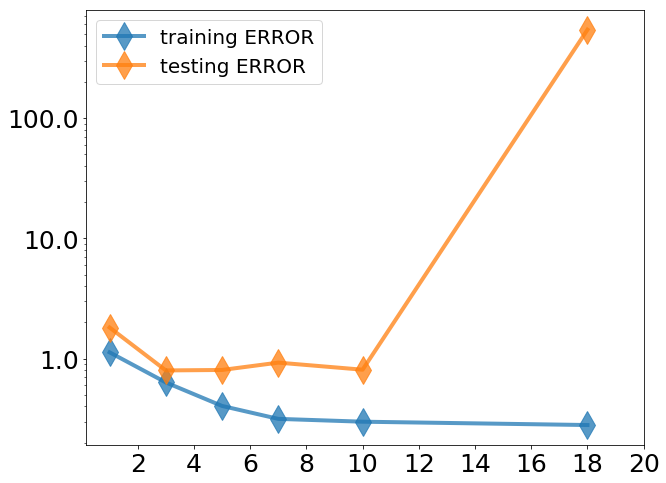

I recommend degree 3


In [14]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plotting a line with markers where there's an actual x value.
ax.semilogy(degrees, training_error, lw=4, marker='d', markersize=20, alpha=0.75, label='training ERROR')
ax.semilogy(degrees, testing_error, lw=4, marker='d', markersize=20, alpha=0.75, label='testing ERROR')

ax.set_xticks(np.arange(2,21,2))

ax.set_xticklabels(ax.get_xticks(), fontsize=25)
ax.set_yticklabels(ax.get_yticks(), fontsize=25)   

ax.legend(fontsize=20, loc=0)

plt.show()
print('I recommend degree 3')

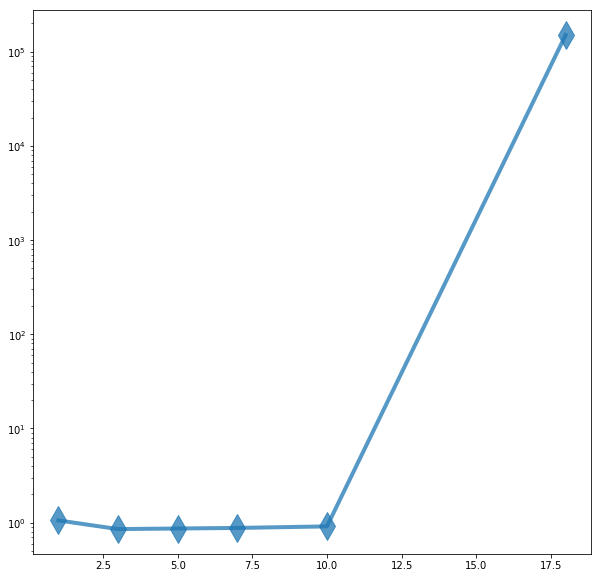

In [66]:
nFolds = 5
degrees = np.array([1, 3, 5, 7, 10, 18])
mean_mse = np.zeros(degrees.shape[0])
J = np.zeros(degrees.shape[0])

for i,degree in enumerate(degrees):
    for iFold in range(nFolds):
        XtiP = ml.transforms.fpoly(Xtr, degree,False)
        XtiP,params = ml.transforms.rescale(XtiP)
        Xti,Xvi,Yti,Yvi = ml.crossValidate(XtiP,Ytr,nFolds,iFold) # use ith block as validation
        Xvi,params = ml.transforms.rescale(Xvi)
        learner = ml.linear.linearRegress(Xti,Yti)# TODO: train on Xti, Yti, the data for this fold
        J[iFold] = learner.mse(Xvi,Yvi) # TODO: now compute the MSE on Xvi, Yvi and save it
    # the overall estimated validation error is the average of the error on each fold
    mean_mse[i] = np.mean(J)
    
f,ax = plt.subplots(1,1,figsize = (10,10))
ax.semilogy(degrees, mean_mse, lw=4, marker='d', markersize=20, alpha=0.75, label='mean_mse')


    

In [18]:
#The MSE estimates in the 5 fold behave similarly to the testing MSE evaluated on the actual test data.
#In the beginning, the MSE is relatively low up until degree 10 and in degree 18, it is clear that our 
#function has overfit the model.

In [19]:
#I recommend degree 3 because it has the lowest MSE.

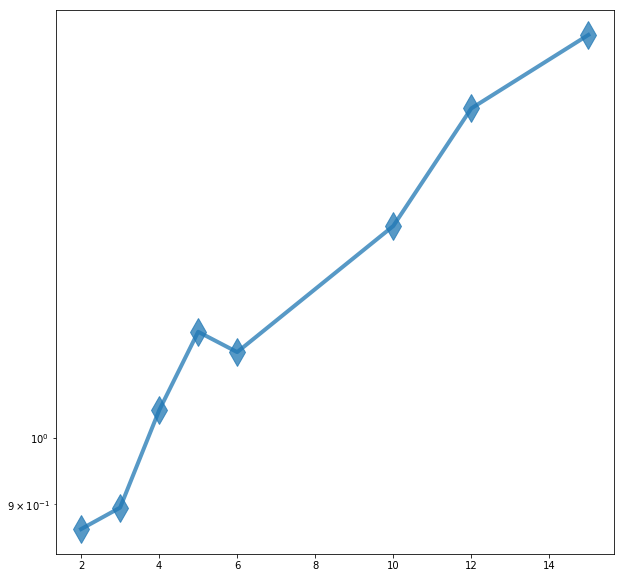

In [74]:
nFolds = np.array([2, 3, 4, 5, 6, 10, 12, 15])
degree = 3
#degrees = np.array([1, 3, 5, 7, 10, 18])
mean_mse = np.zeros(8)
#J = np.zeros(degrees.shape[0])

for i,nFold in enumerate(nFolds):
    J = np.zeros(nFolds[i])
    for iFold in range(nFolds[i]):
        XtiP = ml.transforms.fpoly(Xtr, degree,False)
        XtiP,params = ml.transforms.rescale(XtiP)
        Xti,Xvi,Yti,Yvi = ml.crossValidate(XtiP,Ytr,nFolds[i],iFold) # use ith block as validation
        Xvi,params = ml.transforms.rescale(Xvi)
        Xti,params = ml.transforms.rescale(Xti)
        learner = ml.linear.linearRegress(Xti,Yti)# TODO: train on Xti, Yti, the data for this fold
        J[iFold] = learner.mse(Xvi,Yvi) # TODO: now compute the MSE on Xvi, Yvi and save it
    # the overall estimated validation error is the average of the error on each fold
    mean_mse[i] = np.mean(J)
    
f,ax = plt.subplots(1,1,figsize = (10,10))
ax.semilogy(nFolds, mean_mse, lw=4, marker='d', markersize=20, alpha=0.75, label='mean_mse')

In [27]:
#I observe that the mean MSE is steadily growing larger. I think that is because as 
#the number of folds grow larger, there is not enough data being resserved as testing data. 
#therefore the mean MSE is getting larger

In [ ]:
#Statement of Collaboration
#For this assignment I collaborated with Jason Lee and Jorge Carlos.
#I discussed individually with both of them about transforming the data and why it is needed to rescale 
#the data for both training and testing data so that the data can be represented consistantly in the model.